# Flightpath Optimization

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../source/Noise/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from NoiseBayes import NoiseBayes

from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian

# specify which navigation class we are using
from NavigationSegment import NavigationSegment as Navigation
from NavigationMultiSegment import NavigationMultiSegment as NavigationMulti

#from Optimization.DAE import Objective as objective_class
from Optimization.Optimization import Optimization as Optimizer
from Constraints import Constraints

from Flight import Flight

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.4, 0.6], [0.6, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_steps = 500

sigma = 0.05  # std deviation for gaussian-type measurements. Get pointwise data for sigma -> 0
radius = 0.05  # truncation radius for truncation-style measurements

meshDim = 20  # discretization parameter (1D) for FOM
meshDim_drone = 10  # discretization parameter (1D) for subdomain in truncation-type measurements
polyDim = 3

utility_mode = "A"

transition_times = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])

# vary initial position and heading in each segment
subcontrols = [2]
fixed_control_indices=[3, 4]
fixed_control_values=[1, 0]
alpha_init = np.array([0.8, 0.4, 3, 
                         2, 2, 3.5, 5])

## Setup

In [3]:
tStart = time.time()

# initialize full-order model
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim)
n_para = fom.n_para

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

# initialize navigation
navigation = NavigationMulti(grid_t = np.linspace(0, 1, n_steps), 
                             transition_times = transition_times, 
                             subcontrols = subcontrols)
navigation.fix_controls(fixed_control_indices=fixed_control_indices, 
                        fixed_control_values=fixed_control_values)

# point-wise measurements
detector = DetectorPointwise(fom)

# initialize drone
drone = Drone(detector=detector, navigation=navigation, fom=fom)

# set noise model
noise = NoiseBayes(grid_t = drone.grid_t)
noise.parameterize_noise_model(c_scaling = 1e+3, c_diffusion = 0)
inversion = InverseProblem(fom, drone, noise=noise)

# initialize utility functions
utility = OEDUtility(default_mode=utility_mode)

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 0.367825984954834 s


In [4]:
# compute one solution for nicer visualization below
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

## Initial position

/Users/nicole/git/m2dtIceSheet/notebooks/../source/InverseProblem.py:240: UserWarning: InverseProblem.get_states: No saved states. Computing and saving with standard basis.
  warnings.warn(


A-OED: 1.7602952960920293


(-0.05, 1.05)

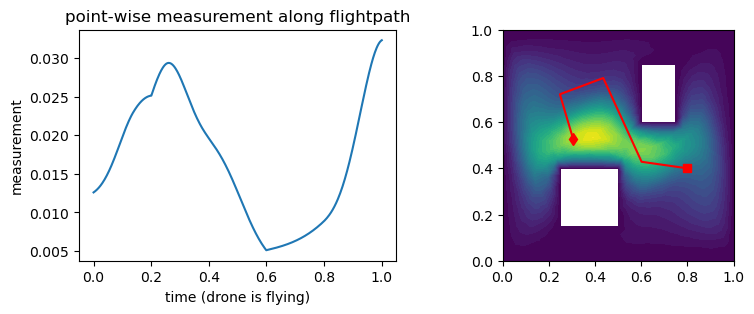

In [5]:
# compute flight
flight = drone.plan_flight(alpha=alpha_init, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)

# compute posterior
posterior = inversion.compute_posterior(alpha=alpha_init)
util_ref = utility.eval_utility(posterior)
print("{}-OED:".format(utility_mode), util_ref)

fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])
axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

axs[0].plot(grid_t, data)
axs[0].set_xlabel("time (drone is flying)")
axs[0].set_ylabel("measurement")
axs[0].set_title("point-wise measurement along flightpath")
axs[0].set_xlim(grid_t[0]-0.05, grid_t[-1]+0.05)

## Optimization

In [6]:
constraints = Constraints(navigation = navigation)

lower = np.array([0, 0, 0.8, 0.4, -np.infty, -np.infty, -np.infty, -np.infty, -np.infty])
constraints.set_bounds(lower, bool_lower = True)

upper = np.array([1, 1, 0.8, 0.4, +np.infty, +np.infty, +np.infty, +np.infty, +np.infty])
constraints.set_bounds(upper, bool_lower = False)

In [7]:
problem_obj = Optimizer(utility=utility, inverse_problem=inversion, constraints=constraints)

problem_obj.add_option("hessian_approximation", "limited-memory")
problem_obj.add_option("tol", 1e-3)
#problem_obj.add_option("max_iter", 3)

/Users/nicole/anaconda3/envs/flightpath-OED/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [8]:
x0 = np.hstack([flightpath[:, i] for i in range(fom.n_spatial)])
x0 = np.hstack([x0, alpha_init])

In [9]:
solution, info = problem_obj.solve(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     2796
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1005
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1000
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1000
Total number of inequality c

In [10]:
(flightpath_1d_opt, controls_opt) = problem_obj.var_splitter(solution)

flight_controlled = Flight(navigation=navigation, alpha = controls_opt)
flight_by_path = Flight(navigation=navigation, flightpath = flightpath_1d_opt)

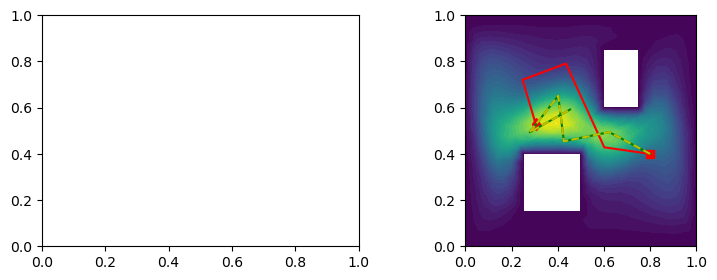

In [11]:
fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])

axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")


axs[1].plot(flight_by_path.flightpath[:, 0], flight_by_path.flightpath[:, 1], color="g")
axs[1].plot(flight_controlled.flightpath[:, 0], flight_controlled.flightpath[:, 1], color="y", linestyle = "--")

In [14]:
navigation.get_trajectory(controls_opt)

(array([[0.8       , 0.4       ],
        [0.79823135, 0.4009423 ],
        [0.7964627 , 0.4018846 ],
        [0.79469405, 0.40282689],
        [0.7929254 , 0.40376919],
        [0.79115675, 0.40471149],
        [0.7893881 , 0.40565379],
        [0.78761945, 0.40659608],
        [0.7858508 , 0.40753838],
        [0.78408215, 0.40848068],
        [0.7823135 , 0.40942298],
        [0.78054485, 0.41036528],
        [0.7787762 , 0.41130757],
        [0.77700755, 0.41224987],
        [0.7752389 , 0.41319217],
        [0.77347025, 0.41413447],
        [0.7717016 , 0.41507677],
        [0.76993295, 0.41601906],
        [0.7681643 , 0.41696136],
        [0.76639565, 0.41790366],
        [0.764627  , 0.41884596],
        [0.76285835, 0.41978825],
        [0.7610897 , 0.42073055],
        [0.75932105, 0.42167285],
        [0.7575524 , 0.42261515],
        [0.75578375, 0.42355745],
        [0.7540151 , 0.42449974],
        [0.75224645, 0.42544204],
        [0.7504778 , 0.42638434],
        [0.748

In [12]:
please stop here

SyntaxError: invalid syntax (1680074362.py, line 1)

In [ ]:
vertices = np.array([[0.7, 0.3], [0.5, 0.5], [0.2, 0.5], [0.1,0.1]])

problem_obj = objective_class(grid_t, utility, inversion, 
                              piecewise_constant=5,
                              use_exact_DAE = False,
                              circle_mode = False,
                              enforce_initial_position = False,
                              # enforce_initial_position = True,
                              enforce_final_position = False,
                              # enforce_final_position = True,
                              periodic = False,
                              reg_strength = 1e-5,
                              OED_utility_mode = utility_mode,
                              # OED_utility_mode = "mix",
                              # OED_mix = {"A": 1e-2, "E": 1.0},
                              # v_lower = 0.1,
                              # v_upper = 3,
                              acc_lower = -np.inf,
                              acc_upper = np.inf,
                              # omega_upper = 100,
                              # omega_lower = -100,
                              omega_acc_upper = np.inf,
                              omega_acc_lower = -np.inf,
                              build_video = False,
                              x0 = flightpath[0,0],
                              y0 = flightpath[0,1],
                              x_final = flightpath[-1,0],
                              y_final = flightpath[-1,1],
                              # x0 = 0.1,
                              # y0 = 0.1,
                              # x_final = 0.7,
                              # y_final = 0.3,
                              obstacle_buffer = 0.05,
                              # L = 3.0,
                             )